In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Cleaning and Visualisation

In [80]:
data = pd.read_csv("data/fuelPrice_NSW.csv", parse_dates=['PriceUpdatedDate'])

print(f"Dataset size before cleaning: {data.shape[0]}")

# Replace whitespace with NaN
data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Convert Price to numeric
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

# Create separate date and time columns
data['Date'] = data['PriceUpdatedDate'].dt.date
data['Time'] = data['PriceUpdatedDate'].dt.time

# Drop all rows with missing or NaN values
data.dropna(inplace=True)

# Drop all duplicate rows
data.drop_duplicates(inplace=True)

print(f"Dataset size after cleaning: {data.shape[0]}")

data.head(n=-1)

Dataset size before cleaning: 98925
Dataset size after cleaning: 96854


,ServiceStationName,FuelCode,PriceUpdatedDate,Price,Latitude,Longitude,Date,Time
0,7-Eleven Minchinbury,E10,2025-08-31 22:10:00,159.9,-33.778213,150.808089,2025-08-31,22:10:00
1,7-Eleven Minchinbury,U91,2025-08-31 22:10:00,163.9,-33.778213,150.808089,2025-08-31,22:10:00
2,7-Eleven Minchinbury,P95,2025-08-31 22:10:00,178.9,-33.778213,150.808089,2025-08-31,22:10:00
3,7-Eleven Minchinbury,P98,2025-08-31 22:10:00,185.9,-33.778213,150.808089,2025-08-31,22:10:00
4,7-Eleven Blacktown,P98,2025-08-31 18:44:00,188.9,-33.754838,150.891467,2025-08-31,18:44:00
...,...,...,...,...,...,...,...,...
98919,7-Eleven Croydon Park,E10,2016-08-01 00:28:00,103.9,-33.894219,151.111471,2016-08-01,00:28:00
98920,7-Eleven Croydon Park,P98,2016-08-01 00:28:00,121.9,-33.894219,151.111471,2016-08-01,00:28:00
98921,7-Eleven Croydon Park,U91,2016-08-01 00:28:00,105.9,-33.897687,151.099818,2016-08-01,00:28:00
98922,7-Eleven Croydon Park,P98,2016-08-01 00:28:00,121.9,-33.897687,151.099818,2016-08-01,00:28:00


In [81]:
# Filter outliers using IQR method
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter
data = data[(data['Price'] >= lower_bound) & (data['Price'] <= upper_bound)]

print(f"Dataset size after removing price outliers: {data.shape[0]}")

Dataset size after removing price outliers: 96522


In [82]:
# Group by Fuel and Date, then select Price and find the minimum
daily_min = data.groupby(['FuelCode', 'Date'])['Price'].min().reset_index()

# Rename the column to be clear
daily_min.rename(columns={'Price': 'DailyMinPrice'}, inplace=True)

daily_min.head(n=-1)

,FuelCode,Date,DailyMinPrice
0,DL,2016-10-06,106.9
1,DL,2016-10-17,110.9
2,DL,2016-11-23,110.8
3,DL,2016-11-24,110.9
4,DL,2017-01-04,118.9
...,...,...,...
16157,U91,2025-08-26,159.9
16158,U91,2025-08-27,159.9
16159,U91,2025-08-28,157.9
16160,U91,2025-08-29,166.9


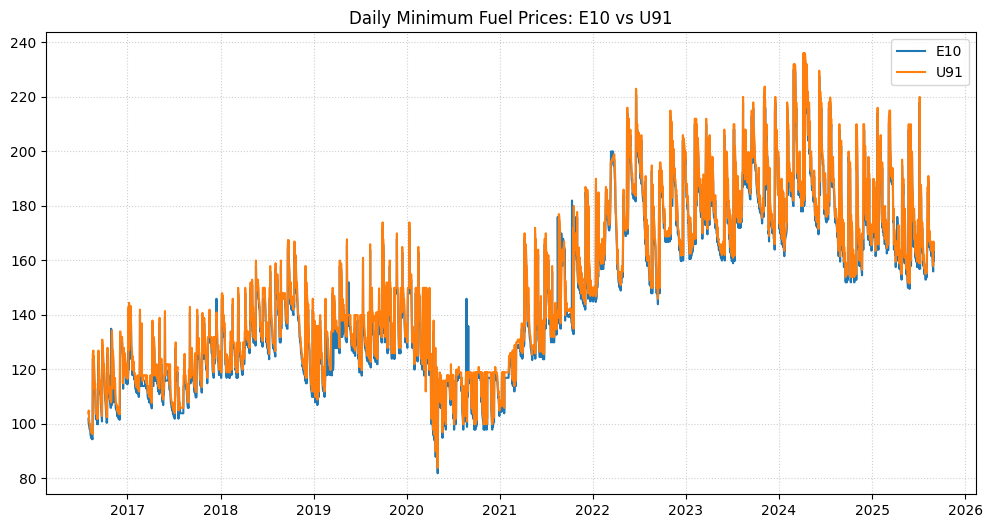

In [83]:
e10_data = daily_min[daily_min['FuelCode'] == 'E10']
u91_data = daily_min[daily_min['FuelCode'] == 'U91']

plt.figure(figsize=(12, 6))
plt.plot(e10_data['Date'], e10_data['DailyMinPrice'], label='E10')
plt.plot(u91_data['Date'], u91_data['DailyMinPrice'], label='U91')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.title("Daily Minimum Fuel Prices: E10 vs U91")
plt.show()

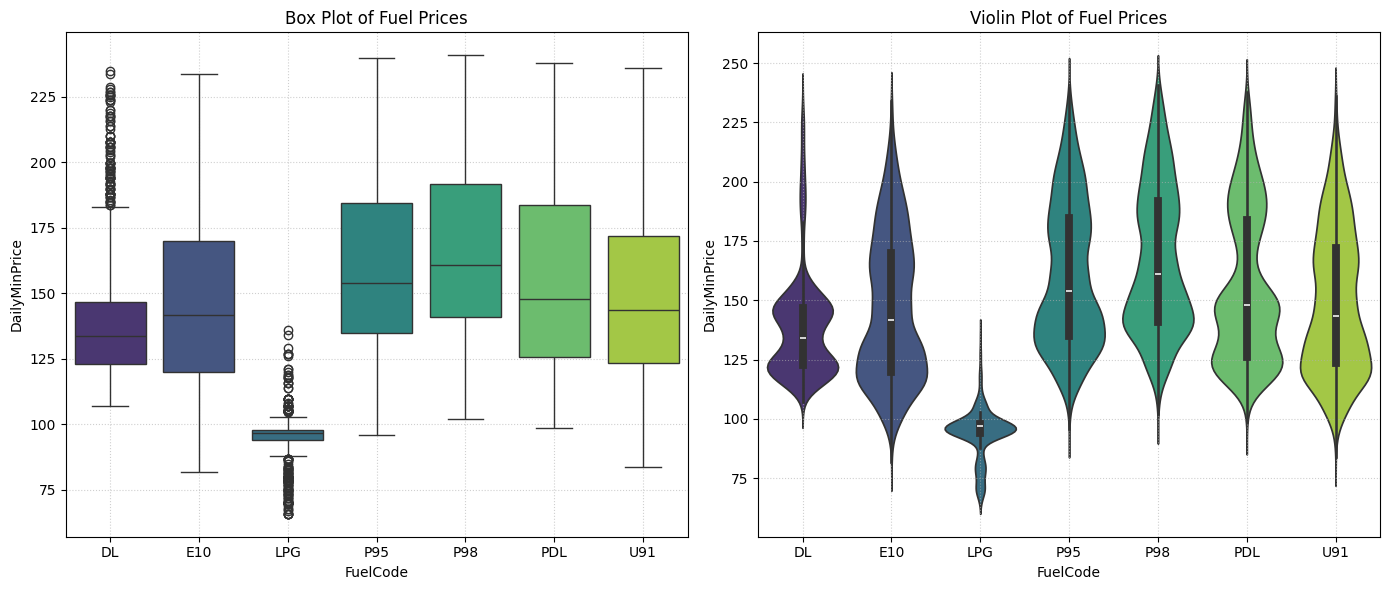

In [84]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='FuelCode', y='DailyMinPrice', data=daily_min, hue='FuelCode', legend=False, palette='viridis')
plt.title('Box Plot of Fuel Prices')
plt.grid(True, linestyle=':', alpha=0.6)

plt.subplot(1, 2, 2)
sns.violinplot(x='FuelCode', y='DailyMinPrice', data=daily_min, hue='FuelCode', legend=False, palette='viridis')
plt.title('Violin Plot of Fuel Prices')
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

# Forecasting Next-Day Prices